In [1]:
import cv2
import numpy as np
import time
import threading

from src.display import showarray
from src.feed import LiveFrameProcessor
from src.video import VideoHandler
from src.processing.analyzers import ThreadableAnalyzer
from src.processing import features, calc

In [2]:
dice_mon = cv2.imread("Medium_2_49.jpg")

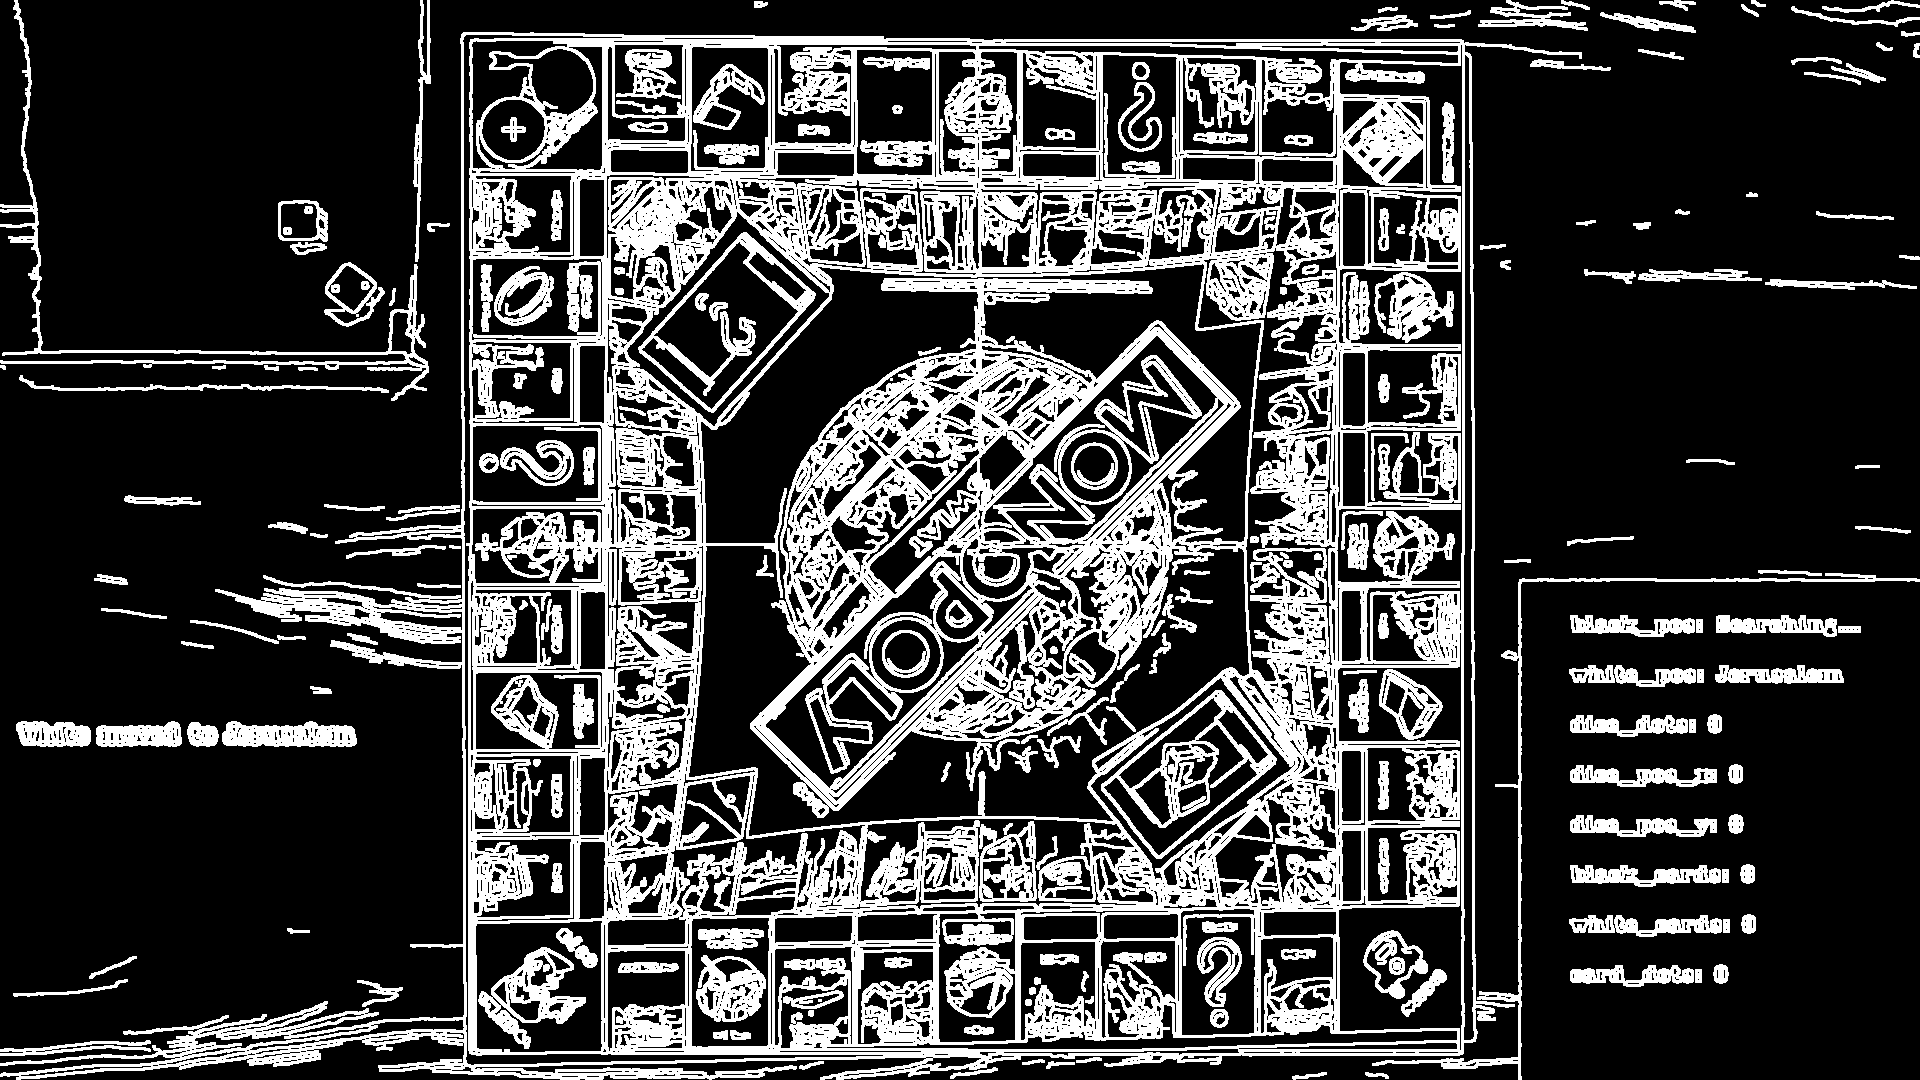

In [5]:
dice_mon_edges = features.get_clear_edges(dice_mon, 80, 30)
showarray(dice_mon_edges)

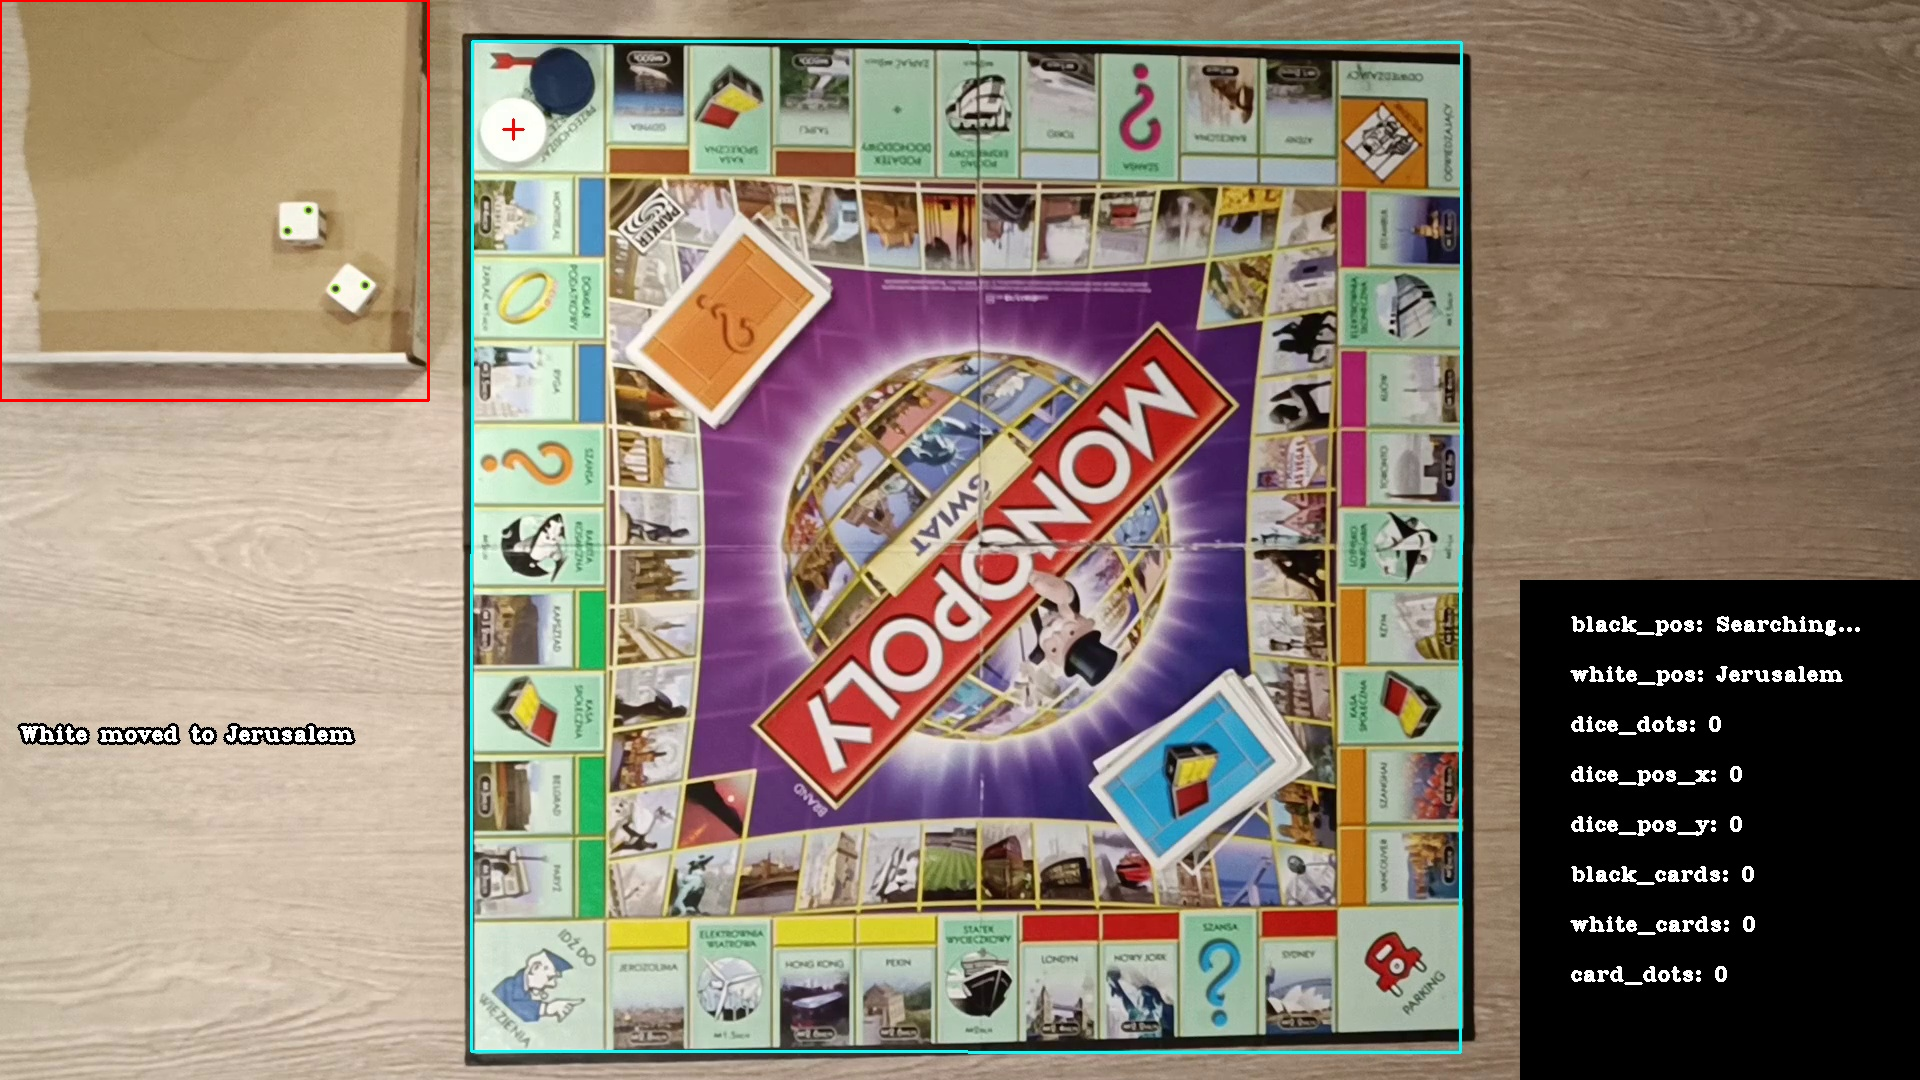

In [6]:
dice_area_rect = features.find_dice_throwing_rect(dice_mon, 80, 30)

showarray(cv2.rectangle(dice_mon.copy(), dice_area_rect, (0, 0, 255), 2))

In [55]:
def get_dots_detector() -> cv2.SimpleBlobDetector:
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 40
    params.maxArea = 120
    params.filterByCircularity = True
    params.minCircularity = 0.8
    params.filterByConvexity = True
    params.minConvexity = 0.8
    params.filterByInertia = True
    params.minInertiaRatio = 0.8
    return cv2.SimpleBlobDetector_create(params)

dots_detector = get_dots_detector()

In [44]:
class DotsAnalyzer(ThreadableAnalyzer):
    def __init__(
        self,
        blob_detector: cv2.SimpleBlobDetector,
        img_transformer = lambda x: x,
        threaded: bool = False,
    ) -> None:
        self.dice_keypoints = []
        self.card_keypoints = []
        self.blob_detector = blob_detector
        self.img_transformer = img_transformer
        super().__init__(threaded)

    def analyze_job(
        self,
        frame: np.ndarray,
        dice_area_rect: tuple[int, int, int, int] | None = None,
        board_points: np.ndarray | None = None,
        **kwargs
    ) -> None:
        dice_keypoints = []
        card_keypoints = []
        transformed_frame = self.img_transformer(frame)
        keypoints = self.blob_detector.detect(transformed_frame)
        for kp in keypoints:
            if dice_area_rect is not None:
                if calc.is_inside_bounding_rect(kp.pt, dice_area_rect):
                    dice_keypoints.append(kp)
                else:
                    card_keypoints.append(kp)
            else:
                card_keypoints.append(kp)
        if board_points is not None:
            card_keypoints = [
                kp for kp in card_keypoints if cv2.pointPolygonTest(board_points, kp.pt, False) < 0
            ]
        self.dice_keypoints = dice_keypoints
        self.card_keypoints = card_keypoints

    def mutate_frame(self, frame: np.ndarray) -> np.ndarray:
        frame = cv2.drawKeypoints(
            frame,
            self.dice_keypoints,
            np.array([]),
            (0, 0, 255),
            cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )
        frame = cv2.drawKeypoints(
            frame,
            self.card_keypoints,
            np.array([]),
            (20, 255, 150),
            cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )
        return frame

    def get_context(self) -> dict:
        return {
            "dice_dots": self.dice_keypoints,
            "card_dots": self.card_keypoints,
        }

In [56]:
analyzer = DotsAnalyzer(dots_detector, threaded=True)
processor = LiveFrameProcessor("feed", 400, 800)
with VideoHandler("data/recordings/Medium_3.mp4") as vh:
    initial_frame = vh.get_frame(0)
    additional_context = {
        "dice_area_rect": features.find_dice_throwing_rect(initial_frame)
    }
    vh.go_through_video(processor, [analyzer], additional_context=additional_context)

In [50]:
additional_context

{'dice_area_rect': None}